In [15]:
!sudo apt install tesseract-ocr
!sudo apt install tesseract-ocr-rus
!pip install pytesseract
!pip install transformers
!pip install tensorflow-addons

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-rus is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.0 MB/s eta 0:00:00


In [42]:
import tensorflow as tf
from tensorflow import keras
from transformers import TFBertModel, BertTokenizer
import pytesseract
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import pandas as pd
import os
import string
import torch
from torchvision import transforms, models
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
classes = sorted(['Birth_certificate', 'Employment_contract', 'Military_ticket', 'Pisnoe',
           'employment_record', 'marriage_certificate', 'passport', 'snils'])
num_classes = len(classes)
img_height = img_width = 224

In [5]:
# clear_text and tokenizer

def clear_text(text):
  '''
  remove punctuation, make text lower
  '''
  for char in string.punctuation + '_—„©‚':
    text = text.replace(char, ' ')
  text = ' '.join([w.lower() for w in text.split()])
  return text

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize(texts, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for text in texts:
        inputs = tokenizer(text, truncation=True, max_length=512, return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return input_ids, input_masks, input_segments


In [89]:
# loading Tim model

class_names = ['Bitrth_certificate', 'Employment_contract', 'Military_ticket', 'Pisnoe',
           'employment_record', 'marriage_certificate', 'passport', 'snils']

model = torch.load('/content/drive/MyDrive/pytorch_model/model.pth', map_location=torch.device('cpu'))
model.eval()

transforms = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])

def ImgClass(PATH):
  imge = Image.open(PATH)
  image = transforms(imge)
  image = image.unsqueeze(0)
  preds = model(image)
  name_class = class_names[int(torch.argmax(preds))]

  return name_class

In [41]:
# loading my model

reloaded_model = tf.keras.models.load_model('/content/drive/MyDrive/multimodal_model')
reloaded_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                        

In [123]:
image_example = pathlib.Path('/content/drive/MyDrive/Dataset_copy/passport/4.jpg')

In [124]:
# some utility functions

def get_text_and_resized_image(image_path):

  with Image.open(image_path) as img:
    # getting text
    img_text = pytesseract.image_to_string(img,
                                         config='--psm 3 -c tessedit_char_blacklist= ‘][|/`',
                                         lang='rus')

    # resizing image
    img_float32 = tf.image.convert_image_dtype(img, tf.float32)
    img_tensor = tf.convert_to_tensor(img_float32)
    img_resized = tf.image.resize(img_tensor, size=[224,224],
                                          method=tf.image.ResizeMethod.LANCZOS3,
                                          antialias=True)

  return img_text, tf.expand_dims(img_resized, 0)


In [125]:
def get_text_features(text):
  # clearing text
  text = clear_text(text)

  # tokenizing text
  ids, mask, t_types = tokenize([text], tokenizer)

  # stretching features
  for feature in [ids, mask, t_types]:
    feature[0] = np.pad(feature[0], ((0, 0), (0, 512 - feature[0].shape[1])), mode='constant', constant_values=0)

  # squeezing and converting to tensor
  for feature in [ids, mask, t_types]:
    feature[0] = tf.convert_to_tensor(feature[0])

  return ids[0], mask[0], t_types[0]

In [126]:
ex_text, ex_resized = get_text_and_resized_image(image_example)
ids, mask, t_types = get_text_features(ex_text)

In [127]:
ex_resized.shape, ids.shape, mask.shape, t_types.shape

(TensorShape([1, 224, 224, 3]),
 TensorShape([1, 512]),
 TensorShape([1, 512]),
 TensorShape([1, 512]))

In [130]:
# passing to model

y_pred_tim = ImgClass(image_example)
y_pred_multimodal = reloaded_model.predict(x=[ex_resized, ids, mask, t_types])

1/1 [==============================] - 3s 3s/step


(array([[1.6844540e-03, 1.3257270e-02, 6.0496747e-02, 2.0372673e-04,
         2.5666291e-02, 7.7669355e-03, 8.9039320e-01, 5.3143292e-04]],
       dtype=float32),
 'passport')

In [132]:
class_names[np.argmax(y_pred_multimodal)], y_pred_tim

('passport', 'passport')

### Создание сплитов


In [43]:
# why are we still here.... just to suffer...

In [44]:
batch_size = 8
img_height = 224
img_width = 224
num_classes = 8

In [45]:
image_ds_size = text_ds_size = 185

In [46]:
def clear_text(text):
  '''
  remove punctuation, make text lower
  '''
  for char in string.punctuation + '_—„©‚':
    text = text.replace(char, ' ')
  text = ' '.join([w.lower() for w in text.split()])
  return text

In [47]:
data_path = "/content/drive/MyDrive/Dataset_text"
data_dir = pathlib.Path(data_path).with_suffix('')

def get_texts_by_class(data_dir):
  # tuple (text, label)
  label_text_tuples = []
  folders = sorted([x for x in data_dir.iterdir() if x.is_dir()])
  for folder in folders:
    class_name = folder.parts[-1]
    files = sorted(folder.glob('*.txt'))
    for file in files:
      with open(file, 'r') as f:
        text = f.read().replace('\n', ' ')
        text = clear_text(text)
      label_text_tuples.append((class_name, text))

  return label_text_tuples

In [48]:
text_label_tuples = get_texts_by_class(data_dir)

In [49]:
# Using tokenizer for mapping text

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize(texts, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for text in texts:
        inputs = tokenizer(text, truncation=True, max_length=512, return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return input_ids, input_masks, input_segments


label_tokenized_text_tuples = []
texts = [x[1] for x in text_label_tuples]
ids, masks, token_types = tokenize(texts, tokenizer)

for i in range(len(text_label_tuples)):
  label_tokenized_text_tuples.append( (text_label_tuples[i][0], [ids[i], masks[i], token_types[i]]) )

In [50]:
data_path = "/content/drive/MyDrive/Dataset_resized"
data_dir = pathlib.Path(data_path).with_suffix('')

def get_images_by_class(data_dir):
  # tuple (text, image)
  label_image_tuples = []
  folders = sorted([x for x in data_dir.iterdir() if x.is_dir()])
  for folder in folders:
    class_name = folder.parts[-1]
    files = sorted(folder.glob('*.jpg'))
    for image in files:
      with Image.open(image) as img:
        img = tf.convert_to_tensor(img)
      label_image_tuples.append((class_name, img))

  return label_image_tuples

In [51]:
lable_image_tuples = get_images_by_class(data_dir)

In [52]:
images = [x[1] for x in lable_image_tuples]
text_tokens = [x[1] for x in label_tokenized_text_tuples]
labels = [x[0] for x in lable_image_tuples]

In [53]:
text_tokens[3]

[<tf.Tensor: shape=(1, 74), dtype=int32, numpy=
 array([[   101,  11963,    551,  20387,  10517, 100439,  10205,  10851,
            555,  11663,  18565,  17006,    557,  35912,  11579,    555,
          27332,  20928,  11980,  29482,  28171,  28445,  11980,  45117,
          10385,  65794,    555,  32246,  13701,  23339, 102167,  95301,
          10179,    555,    557,  10316,  45228,   1779,  10983,  34606,
          11815,    560,    549,  16176,  10475,  78070,  14525,    555,
            542,  51798,  98280,  10384,    561,  82562,  91390,    558,
          30318,  12528,  96655,  17371,  36712,  10179,    569,    549,
          38146,  14402,  35261,  10541,  77879,  11184,  85055,  10923,
            541,    102]], dtype=int32)>,
 <tf.Tensor: shape=(1, 74), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [54]:
# converting text features to one shape (to max 512 len for now cuz I'm stupid)

def stretch_to_len(array, len=512):
  assert array.shape[0] == 1
  if array.shape[1] < len:
    array = np.pad(array, ((0, 0), (0, 512 - array.shape[1])), mode='constant', constant_values=0)
  return array

for i, features in enumerate(text_tokens):
  for j in range(len(features)):
    # also manually adding one dim to text features for bert model batching
    text_tokens[i][j] = stretch_to_len(text_tokens[i][j])


In [55]:
from sklearn.model_selection import train_test_split

train_img_X, val_img_X, train_text_X, val_text_X, train_y, val_y = train_test_split(images, text_tokens, labels, test_size=0.2)


print(len(train_img_X), len(train_text_X), len(train_y))
print(len(val_img_X), len(val_text_X), len(val_y))

148 148 148
37 37 37


In [56]:
def hand_made_one_hot(labels):
  unique_labels = []
  for label in labels:
    if label not in unique_labels:
      unique_labels.append(label)

  unique_labels.sort()
  ohe_labels = []
  for i, label in enumerate(labels):
    ohe_labels.append(np.zeros(len(unique_labels)))
    ohe_labels[i][unique_labels.index(label)] = 1

  return ohe_labels


In [57]:
print(f'train_y before ohe: {train_y}')

train_y = hand_made_one_hot(train_y)
val_y = hand_made_one_hot(val_y)

print(f'train_y after ohe: {train_y}')

train_y before ohe: ['Birth_certificate', 'employment_record', 'Birth_certificate', 'Military_ticket', 'Birth_certificate', 'Employment_contract', 'Employment_contract', 'Birth_certificate', 'passport', 'employment_record', 'marriage_certificate', 'marriage_certificate', 'Pisnoe', 'snils', 'Birth_certificate', 'marriage_certificate', 'Pisnoe', 'passport', 'snils', 'Employment_contract', 'snils', 'passport', 'employment_record', 'Employment_contract', 'passport', 'snils', 'Birth_certificate', 'marriage_certificate', 'Birth_certificate', 'passport', 'Military_ticket', 'Military_ticket', 'passport', 'Birth_certificate', 'marriage_certificate', 'employment_record', 'marriage_certificate', 'employment_record', 'employment_record', 'Birth_certificate', 'snils', 'snils', 'marriage_certificate', 'Employment_contract', 'passport', 'Military_ticket', 'Birth_certificate', 'Employment_contract', 'marriage_certificate', 'marriage_certificate', 'passport', 'employment_record', 'snils', 'Military_tic

In [58]:
# :))
train_text_X = tf.convert_to_tensor(np.array(train_text_X))
train_img_X = tf.convert_to_tensor(train_img_X)
train_y = tf.convert_to_tensor(train_y)

val_text_X = tf.convert_to_tensor(np.array(val_text_X))
val_img_X = tf.convert_to_tensor(val_img_X)
val_y = tf.convert_to_tensor(val_y)

In [59]:
!pip install tensorflow-addons

### Метрики

In [114]:
# checking metrics f1, roc_auc, confusion_matrix
import tensorflow_addons as tfa

f1_metric = tfa.metrics.F1Score(num_classes=8, threshold=0.5)
y_pred = reloaded_model.predict(x=[train_img_X, np.squeeze(train_text_X[:, 0]), np.squeeze(train_text_X[:, 1]), np.squeeze(train_text_X[:, 2])])
y_pred.shape, val_y.shape

5/5 [==============================] - 397s 76s/step


((148, 8), TensorShape([37, 8]))

In [115]:
val_y.shape

TensorShape([37, 8])

In [118]:
f1_metric.update_state(train_y, y_pred)
result = f1_metric.result()
result.numpy()

array([0.9411765 , 1.        , 0.9142857 , 0.79999995, 1.        ,
       0.9189189 , 0.9166667 , 1.        ], dtype=float32)

In [117]:
roc_metric = tf.keras.metrics.AUC(num_thresholds=100)
roc_metric.update_state(train_y, y_pred)
roc_metric.result().numpy()

0.9813635

In [121]:
from sklearn.metrics import confusion_matrix

y_val_labels = [np.where(x == 1)[0][0] for x in np.array(train_y)]
y_pred_labels = [np.argmax(x) for x in np.array(y_pred)]

conf_mx = confusion_matrix(y_val_labels, y_pred_labels)

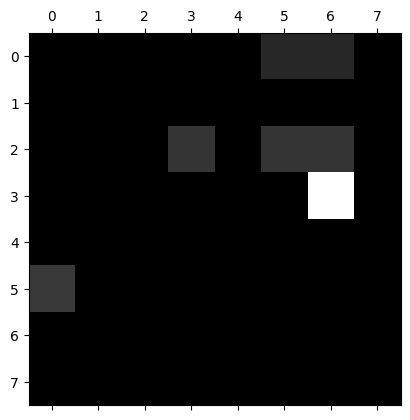

In [122]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [66]:
classes_list = sorted([x.parts[-1] for x in data_dir.iterdir() if x.is_dir()])
classes_list

['Birth_certificate',
 'Employment_contract',
 'Military_ticket',
 'Pisnoe',
 'employment_record',
 'marriage_certificate',
 'passport',
 'snils']